## 필요 모듈 불러오기

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/안봐도보이조_project

/content/drive/MyDrive/안봐도보이조_project


## 이미지 생성기 선언

In [ ]:
# 데이터셋 준비
train_datagen = ImageDataGenerator(rescale=1./255,         # 픽셀 값을 0~1 범위로 변환(scaling)
                                   rotation_range=40,      # 40도까지 회전
                                   width_shift_range=0.2,  # 20%까지 좌우 이동
                                   height_shift_range=0.2, # 20%까지 상하 이동
                                   shear_range=0.2,        # 20%까지 기울임
                                   zoom_range=0.2,         # 20%까지 확대/축소
                                   horizontal_flip=True)   # 좌우 뒤집기
    
train_generator = train_datagen.flow_from_directory('./train_10', # 데이터가 존재하는 디렉토리
                                                    batch_size=100, # 배치사이즈(변경가능)
                                                    class_mode='categorical', # 다중 분류이므로 categorical
                                                    target_size=(128, 128)) # 모델에 입력해줄 데이터 사이즈(변경가능)

valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory('./valid_10',
                                                    batch_size=20,      
                                                    class_mode='categorical', 
                                                    target_size=(128, 128))

test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory('./test_10',
                                                  batch_size=10,      
                                                  class_mode='categorical', 
                                                  target_size=(128, 128),shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


## 모델 생성 및 학습
- ResNet50V2 모델 사용
- early_stopping, modelcheckpoint 적용

In [ ]:
resnet50v2 = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3))

resnet50v2.trainable = False
model = Sequential()
model.add(resnet50v2)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2097216   
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 25,662,666
Trainable params: 2,097,866
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
model.compile(optimizer = Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
model_path = '/content/drive/MyDrive/안봐도보이조_project/송종호/model/resnet50v2.h5'

checkpointer = ModelCheckpoint(filepath=model_path, monitor='val_loss', 
                               save_best_only=True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=100, 
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=30,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/100
100/100 [==============================] - 2178s 22s/step - loss: 1.6504 - accuracy: 0.5746 - val_loss: 0.6729 - val_accuracy: 0.7750
Epoch 2/100
100/100 [==============================] - 236s 2s/step - loss: 0.6230 - accuracy: 0.7942 - val_loss: 0.3530 - val_accuracy: 0.8783
Epoch 3/100
100/100 [==============================] - 87s 870ms/step - loss: 0.4641 - accuracy: 0.8478 - val_loss: 0.3603 - val_accuracy: 0.8833
Epoch 4/100
100/100 [==============================] - 69s 695ms/step - loss: 0.3777 - accuracy: 0.8821 - val_loss: 0.3027 - val_accuracy: 0.9133
Epoch 5/100
100/100 [==============================] - 65s 646ms/step - loss: 0.3391 - accuracy: 0.8969 - val_loss: 0.2145 - val_accuracy: 0.9300
Epoch 6/100
100/100 [==============================] - 65s 647ms/step - loss: 0.2728 - accuracy: 0.9148 - val_loss: 0.2003 - val_accuracy: 0.9383
Epoch 7/100
100/100 [==============================] - 63s 626ms/step - loss: 0.2543 - accuracy: 0.9192 - val_loss: 0.1682 - v

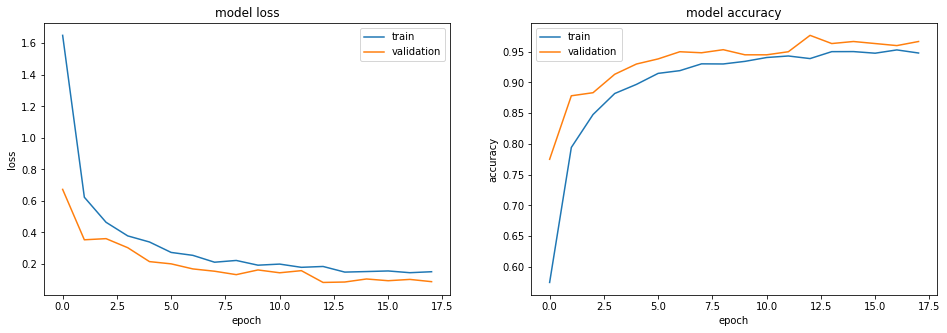

In [ ]:
# 모델 학습 과정 시각화
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [ ]:
model.save('./송종호/resnet50v2_1.h5')

In [ ]:
model = load_model('./송종호/model/resnet50v2.h5')

In [ ]:
# 모델 평가
model.evaluate(test_generator)

50/50 [==============================] - 118s 2s/step - loss: 0.0711 - accuracy: 0.9720


[0.07112594693899155, 0.972000002861023]

In [ ]:
import matplotlib.pyplot as plt 
plt.rc('font', family='NanumBarunGothic')

Text(0.5, 1.0, '0.80확률로 펩시콜라입니다')

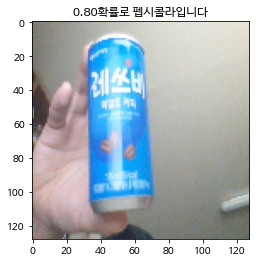

In [ ]:
# 직접 찍은 음료 이미지로 예측 결과 확인

class_dict = {0:'갈아만든배', 1:'레쓰비', 2:'마운틴듀', 3:'밀키스', 4:'스프라이트', 5:'칠성사이다', 6:'코카콜라', 7:'트로피카나망고', 8:'펩시콜라', 9:'환타오렌지'}

test_img = cv2.imread('./123.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(128,128))/255.0
test_img_input = test_img.reshape((1,)+test_img.shape)
pred = model.predict(test_img_input)
pred_class = class_dict[np.argmax(pred, axis=1)[0]]
plt.imshow(test_img)
# print(f'{pred.max():.2f}확률로 {pred_class}입니다')
plt.title(f'{pred.max():.2f}확률로 '+pred_class+'입니다')

In [ ]:
Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1) 

# class_names = ['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'] 
result_dict = dict(map(reversed, test_generator.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))


-- Confusion Matrix --
[[49  0  0  0  0  0  1  0  0  0]
 [ 0 48  0  1  1  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  1  0  0 48  0  0  0  1  0]
 [ 0  0  0  1  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  3  0  1  3  0  0  0 43  0]
 [ 0  1  0  0  0  0  0  0  0 49]]
-- Classification Report --
              precision    recall  f1-score   support

       갈아만든배       1.00      0.98      0.99        50
         레쓰비       0.91      0.96      0.93        50
        마운틴듀       1.00      1.00      1.00        50
         밀키스       0.94      1.00      0.97        50
       스프라이트       0.92      0.96      0.94        50
       칠성사이다       1.00      0.98      0.99        50
        코카콜라       0.98      1.00      0.99        50
     트로피카나망고       1.00      1.00      1.00        50
        펩시콜라       0.98      0.86      0.91        50
       환타오렌지       1.00      0.98      0.99        50

    accuracy          

<AxesSubplot:>

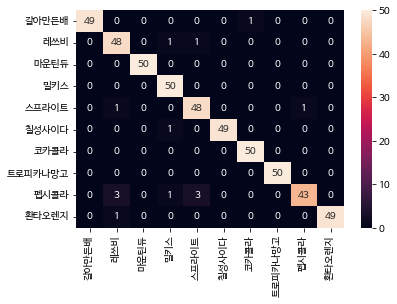

In [ ]:
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'] ,
            yticklabels=['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'] )